In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Query for Provider Specialty Profile: saved to refs_to_nash

In [2]:
query = """
WITH nash_hosps AS (SELECT npi, display_name, organization_name AS hospital  
            FROM npidata n
            LEFT JOIN taxonomy t
            USING(taxonomy_code)
            WHERE entity_type_code = 2
                AND n.location_address_city_name LIKE '%Nashville%'
                AND n.location_address_state_name LIKE '%TN%'
                AND t.display_name = 'General Acute Care Hospital')   --nash_hosps only

--building profile for the referring_provs         
SELECT 
        h.from_npi AS referring_npi, 
        t.display_name AS referring_specialty,
        t.classification, 
        h.patient_count,
        h.transaction_count,
        h.average_day_wait,
        n.organization_name AS referring_organization,
        n.location_address_city_name AS referring_city,
        n.location_address_state_name AS referring_state,
        n.location_address_postal_code AS referring_zipcode,
        nash_hosps.npi AS referred_npi,
        nash_hosps.hospital AS referred_hospital

FROM hop h

INNER JOIN npidata n  --to find their npi info
ON h.from_npi = n.npi

LEFT JOIN taxonomy t --to find their specialty
USING(taxonomy_code)

INNER JOIN nash_hosps   --referred to hospitals
ON h.to_npi = nash_hosps.npi

WHERE 
    --h.to_npi IN (SELECT npi FROM nash_hosps)
    n.entity_type_code < 2
    AND h.average_day_wait < 50
    AND h.transaction_count >= 50;

"""

with sqlite3.connect('data_n/hop_db.sqlite') as db:
    refs_to_nash = pd.read_sql(query, db)

db.close()

In [3]:
refs_to_nash.head()

,referring_npi,referring_specialty,classification,patient_count,transaction_count,average_day_wait,referring_organization,referring_city,referring_state,referring_zipcode,referred_npi,referred_hospital
0,1679521090,Hematology & Oncology Physician,Internal Medicine,36,62,10.306,None,NASHVILLE,TN,37203,1992861314,SETON CORPORATION
1,1043232879,Diagnostic Radiology Physician,Radiology,47,55,18.727,None,GOODLETTSVILLE,TN,37072,1992861314,SETON CORPORATION
2,1174565543,Hematology & Oncology Physician,Internal Medicine,69,143,3.273,None,NASHVILLE,TN,37203,1992861314,SETON CORPORATION
3,1942254883,Diagnostic Radiology Physician,Radiology,52,65,13.154,None,GOODLETTSVILLE,TN,37072,1992861314,SETON CORPORATION
4,1194751354,Medical Oncology Physician,Internal Medicine,37,64,12.641,None,NASHVILLE,TN,37203,1992861314,SETON CORPORATION


In [4]:
refs_to_nash['referred_hospital'] = (
    refs_to_nash['referred_hospital'].
    str.replace('SETON CORPORATION', 'SAINT THOMAS')
    .str.replace('SAINT THOMAS WEST HOSPITAL', 'SAINT THOMAS')
    .str.replace('HCA HEALTH SERVICES OF TENNESSEE, INC.', 'HCA/TRISTAR')
    .str.replace('HTI MEMORIAL HOSPITAL CORPORATION', 'HCA/TRISTAR')
    .str.replace('VANDERBILT UNIVERSITY MEDICAL CENTER', 'VUMC')
)


<ipython-input-4-994327c1df5e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  refs_to_nash['referred_hospital'].


In [5]:
#removes trailing physician in specialty
refs_to_nash['referring_specialty'] = (refs_to_nash['referring_specialty']
                                       .str.replace(' Physician', ''))

In [6]:
#dataframe filtered for service specialties
refs_to_nashb = refs_to_nash[~refs_to_nash['referring_specialty'].isin(['Anatomic Pathology & Clinical Pathology', 
                    'Diagnostic Radiology', 
                    'Emergency Medicine'])]

#### Looking into Specialties

In [7]:
#with service specialties not filtered
refs_to_nashb.groupby('referring_specialty')['patient_count'].sum().nlargest(10)

referring_specialty
Cardiovascular Disease                    94691
Internal Medicine                         91648
Certified Registered Nurse Anesthetist    39020
Anesthesiology                            28496
Family Medicine                           26876
Family Nurse Practitioner                 23740
Nephrology                                20910
Pulmonary Disease                         20527
Acute Care Nurse Practitioner             20141
Gastroenterology                          17006
Name: patient_count, dtype: int64

### Referring Specialty - Referred Hospital Patient Count

In [8]:
spec_to_hosp = pd.DataFrame(refs_to_nashb.groupby(['referring_specialty', 'referred_hospital'])['patient_count'].sum())
spec_to_hosp.reset_index(inplace = True)
spec_to_hosp

,referring_specialty,referred_hospital,patient_count
0,Acute Care Clinical Nurse Specialist,HCA/TRISTAR,166
1,Acute Care Clinical Nurse Specialist,VUMC,128
2,Acute Care Nurse Practitioner,HCA/TRISTAR,2931
3,Acute Care Nurse Practitioner,NASHVILLE GENERAL HOSPITAL,53
4,Acute Care Nurse Practitioner,SAINT THOMAS,4021
...,...,...,...
326,Vascular Surgery,VUMC,2754
327,Women's Health Clinical Nurse Specialist,SAINT THOMAS,135
328,Women's Health Nurse Practitioner,HCA/TRISTAR,362
329,Women's Health Nurse Practitioner,SAINT THOMAS,490


In [9]:
#for each specialty, rank the hospital most referred to by patient count
spec_to_hosp["rank"] = spec_to_hosp.groupby("referring_specialty")["patient_count"].rank(method="dense", ascending = False)
spec_to_hosp['rank'] = spec_to_hosp['rank'].astype(int)
spec_to_hosp

,referring_specialty,referred_hospital,patient_count,rank
0,Acute Care Clinical Nurse Specialist,HCA/TRISTAR,166,1
1,Acute Care Clinical Nurse Specialist,VUMC,128,2
2,Acute Care Nurse Practitioner,HCA/TRISTAR,2931,3
3,Acute Care Nurse Practitioner,NASHVILLE GENERAL HOSPITAL,53,4
4,Acute Care Nurse Practitioner,SAINT THOMAS,4021,2
...,...,...,...,...
326,Vascular Surgery,VUMC,2754,1
327,Women's Health Clinical Nurse Specialist,SAINT THOMAS,135,1
328,Women's Health Nurse Practitioner,HCA/TRISTAR,362,3
329,Women's Health Nurse Practitioner,SAINT THOMAS,490,2


In [10]:
spec_to_hosp['rank'].unique()

array([1, 2, 3, 4])

In [11]:
spec_to_hosp['percent'] = spec_to_hosp['patient_count'] / spec_to_hosp.groupby('referring_specialty')['patient_count'].transform('sum')
spec_to_hosp

,referring_specialty,referred_hospital,patient_count,rank,percent
0,Acute Care Clinical Nurse Specialist,HCA/TRISTAR,166,1,0.564626
1,Acute Care Clinical Nurse Specialist,VUMC,128,2,0.435374
2,Acute Care Nurse Practitioner,HCA/TRISTAR,2931,3,0.145524
3,Acute Care Nurse Practitioner,NASHVILLE GENERAL HOSPITAL,53,4,0.002631
4,Acute Care Nurse Practitioner,SAINT THOMAS,4021,2,0.199643
...,...,...,...,...,...
326,Vascular Surgery,VUMC,2754,1,0.464183
327,Women's Health Clinical Nurse Specialist,SAINT THOMAS,135,1,1.000000
328,Women's Health Nurse Practitioner,HCA/TRISTAR,362,3,0.162697
329,Women's Health Nurse Practitioner,SAINT THOMAS,490,2,0.220225


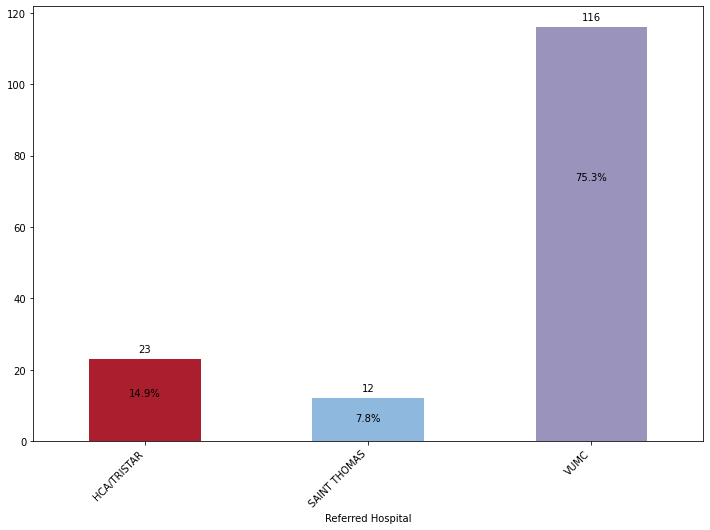

In [12]:
colors= ["#AA1E2D", "#8FB8DE",   "#9A94BC"]

ax = spec_to_hosp[spec_to_hosp['rank'] ==1].groupby('referred_hospital')['rank'].sum().plot(kind = 'bar', 
                                                                                            color = colors,
                                                                                           figsize=(12,8))
plt.xticks(rotation=45, ha = 'right')
plt.xlabel('Referred Hospital')
#plt.title('Count of Specialties for Which a Hospital is the Top Referral')


def add_percentages(ax, spacing=-3):
      for rect in ax.patches:
        y_value = (rect.get_height())*100/154
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'bottom'
        label = "{:.1f}%".format(y_value)
        # Create annotation
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, -10),          
            textcoords="offset points", 
            ha='center',                
            va=va)                      
                                       
  
def add_values(ax, spacing=5):
    for rect in ax.patches:
        y_value = (rect.get_height())
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        label = "{:.0f}".format(y_value)
        # Create annotation
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)                      
                                      

add_percentages(ax)
add_values(ax)


#plt.show()
plt.savefig('fig1.png', dpi = 250)

In [13]:
big_ten_specs = refs_to_nashb.groupby('referring_specialty')['patient_count'].sum().nlargest(10)
big_ten_specs = pd.DataFrame(big_ten_specs)
big_ten_specs.reset_index(inplace = True)
big_ten_specs

,referring_specialty,patient_count
0,Cardiovascular Disease,94691
1,Internal Medicine,91648
2,Certified Registered Nurse Anesthetist,39020
3,Anesthesiology,28496
4,Family Medicine,26876
5,Family Nurse Practitioner,23740
6,Nephrology,20910
7,Pulmonary Disease,20527
8,Acute Care Nurse Practitioner,20141
9,Gastroenterology,17006


In [14]:
#filtering for big ten specialties by patient count
spec_to_hosp_bten = spec_to_hosp[spec_to_hosp['referring_specialty'].isin(big_ten_specs['referring_specialty'])]
spec_to_hosp_bten

,referring_specialty,referred_hospital,patient_count,rank,percent
2,Acute Care Nurse Practitioner,HCA/TRISTAR,2931,3,0.145524
3,Acute Care Nurse Practitioner,NASHVILLE GENERAL HOSPITAL,53,4,0.002631
4,Acute Care Nurse Practitioner,SAINT THOMAS,4021,2,0.199643
5,Acute Care Nurse Practitioner,VUMC,13136,1,0.652202
29,Anesthesiology,HCA/TRISTAR,6058,3,0.212591
30,Anesthesiology,NASHVILLE GENERAL HOSPITAL,95,4,0.003334
31,Anesthesiology,SAINT THOMAS,6851,2,0.240420
32,Anesthesiology,VUMC,15492,1,0.543655
36,Cardiovascular Disease,HCA/TRISTAR,15288,3,0.161451
37,Cardiovascular Disease,NASHVILLE GENERAL HOSPITAL,518,4,0.005470


In [15]:
#bten_unstacked = spec_to_hosp_bten.unstack(level = 1)
#percent breakdown for hospitals big ten specialties refer to 
spec_to_hosp_bten['percent'] = spec_to_hosp_bten['patient_count'] / spec_to_hosp_bten.groupby('referring_specialty')['patient_count'].transform('sum')
spec_to_hosp_bten

<ipython-input-15-844ca501163f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spec_to_hosp_bten['percent'] = spec_to_hosp_bten['patient_count'] / spec_to_hosp_bten.groupby('referring_specialty')['patient_count'].transform('sum')


,referring_specialty,referred_hospital,patient_count,rank,percent
2,Acute Care Nurse Practitioner,HCA/TRISTAR,2931,3,0.145524
3,Acute Care Nurse Practitioner,NASHVILLE GENERAL HOSPITAL,53,4,0.002631
4,Acute Care Nurse Practitioner,SAINT THOMAS,4021,2,0.199643
5,Acute Care Nurse Practitioner,VUMC,13136,1,0.652202
29,Anesthesiology,HCA/TRISTAR,6058,3,0.212591
30,Anesthesiology,NASHVILLE GENERAL HOSPITAL,95,4,0.003334
31,Anesthesiology,SAINT THOMAS,6851,2,0.240420
32,Anesthesiology,VUMC,15492,1,0.543655
36,Cardiovascular Disease,HCA/TRISTAR,15288,3,0.161451
37,Cardiovascular Disease,NASHVILLE GENERAL HOSPITAL,518,4,0.005470


In [16]:
tab3 = spec_to_hosp_bten[['referring_specialty', 'referred_hospital', 'percent']]
tab3

,referring_specialty,referred_hospital,percent
2,Acute Care Nurse Practitioner,HCA/TRISTAR,0.145524
3,Acute Care Nurse Practitioner,NASHVILLE GENERAL HOSPITAL,0.002631
4,Acute Care Nurse Practitioner,SAINT THOMAS,0.199643
5,Acute Care Nurse Practitioner,VUMC,0.652202
29,Anesthesiology,HCA/TRISTAR,0.212591
30,Anesthesiology,NASHVILLE GENERAL HOSPITAL,0.003334
31,Anesthesiology,SAINT THOMAS,0.240420
32,Anesthesiology,VUMC,0.543655
36,Cardiovascular Disease,HCA/TRISTAR,0.161451
37,Cardiovascular Disease,NASHVILLE GENERAL HOSPITAL,0.005470


In [17]:
tab3['referring_specialty']= (tab3['referring_specialty'].str.replace('Physician', ''))

<ipython-input-17-1cdc551def87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab3['referring_specialty']= (tab3['referring_specialty'].str.replace('Physician', ''))


In [18]:
tab3 = tab3.pivot(index="referring_specialty", columns = "referred_hospital", values = "percent")
tab3

referred_hospital,HCA/TRISTAR,NASHVILLE GENERAL HOSPITAL,SAINT THOMAS,VUMC
referring_specialty,,,,
Acute Care Nurse Practitioner,0.145524,0.002631,0.199643,0.652202
Anesthesiology,0.212591,0.003334,0.240420,0.543655
Cardiovascular Disease,0.161451,0.005470,0.234552,0.598526
Certified Registered Nurse Anesthetist,0.299949,NaN,0.409918,0.290133
Family Medicine,0.296473,0.008930,0.117242,0.577355
Family Nurse Practitioner,0.219166,0.000505,0.200674,0.579655
Gastroenterology,0.306892,0.001940,0.243385,0.447783
Internal Medicine,0.316712,0.010017,0.297246,0.376026
Nephrology,0.284266,0.006839,0.255045,0.453850


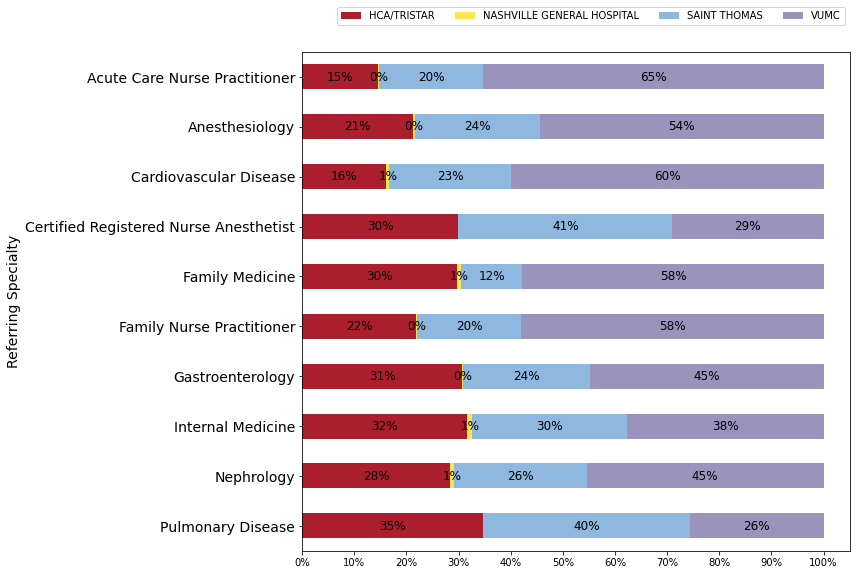

In [19]:
colors= [ "#AA1E2D","#FDE74C", "#8FB8DE",  "#9A94BC"]
ax = tab3.plot(kind = 'barh', stacked = True, ylabel = 'Percent', rot=0, color=colors, figsize=(12,8))
xticks = np.arange(0,1.1,0.1)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
plt.xticks(xticks, xlabels, fontsize=10)
plt.yticks(fontsize = 14)
plt.gca().invert_yaxis()

for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    label_text = f'{width:.0%}'  
    label_x = x + width / 2
    label_y = y + height / 2

    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)


plt.legend(bbox_to_anchor=([1, 1.1, 0, 0]), ncol=4)
plt.ylabel('Referring Specialty', fontsize = 14)
#plt.title('Percent of Hospital Referrals for Top Ten Specialties', y = 1.15, fontweight = 'bold' )

plt.tight_layout()




        
#plt.show()
plt.savefig('fig5.png', dpi = 250)